In [14]:
import numpy as np
import matplotlib.pyplot as plt

class Flow_system:
    def __init__(self, Kvs, P_max=10, num_points=100):
        self.P_max = P_max
        self.num_points = num_points
        self.P = np.linspace(0, P_max, num_points)
        self.curves = []  # Основные кривые
        self.sum_curve = None  # Суммарная кривая
        self.add_curve(Kvs)
        self.operating_point = None

    def add_curve(self, Kvs):
        """Добавление основной кривой"""
        Q = Kvs * np.sqrt(self.P)
        self.curves.append({'Kvs': Kvs, 'Q': Q, 'type': 'main'})
        self._update_sum_curve()

    def _update_sum_curve(self):
        """Обновление суммарной кривой"""
        if len(self.curves) == 2:
            # Создаем общую сетку расходов
            Q_combined = np.union1d(self.curves[0]['Q'], self.curves[1]['Q'])
            P_sum = np.zeros_like(Q_combined)
            
            # Суммируем давления для каждой кривой
            for curve in self.curves:
                P_interp = np.interp(Q_combined, curve['Q'], self.P)
                P_sum += P_interp
                
            self.sum_curve = {
                'Q': Q_combined,
                'P': P_sum,
                'type': 'sum',
                'label': 'Суммарная (Kvs={}+{})'.format(
                    self.curves[0]['Kvs'], 
                    self.curves[1]['Kvs']
                )
            }
        else:
            self.sum_curve = None

    def add_operating_point(self, Q_point):
        """Добавление рабочей точки с приоритетом для суммарной кривой"""
        if self.sum_curve is not None:
            # Ищем точку только на суммарной кривой
            idx = np.argmin(np.abs(self.sum_curve['Q'] - Q_point))
            Q_found = self.sum_curve['Q'][idx]
            P_found = self.sum_curve['P'][idx]
        else:
            # Ищем на всех основных кривых
            closest = []
            for curve in self.curves:
                idx = np.argmin(np.abs(curve['Q'] - Q_point))
                closest.append((curve['Q'][idx], self.P[idx]))
            
            # Выбираем ближайшую точку
            idx = np.argmin([abs(c[0]-Q_point) for c in closest])
            Q_found, P_found = closest[idx]
        
        self.operating_point = (Q_found, P_found)

    def plot_curve(self):
        plt.figure(figsize=(10, 6))
        
        # Рисуем основные кривые
        for curve in self.curves:
            plt.plot(curve['Q'], self.P, 
                    label=f'Kvs={curve["Kvs"]}', 
                    linewidth=2,
                    color='blue')
        
        # Рисуем суммарную кривую
        if self.sum_curve is not None:
            plt.plot(self.sum_curve['Q'], self.sum_curve['P'], 
                    '--', 
                    label=self.sum_curve['label'], 
                    linewidth=2,
                    color='green')
        
        # Настройки графика
        plt.title('Характеристика давление/расход')
        plt.xlabel('Расход (м³/ч)')
        plt.ylabel('Давление (бар)')
        
        # Определение пределов осей
        max_q = max(np.max(c['Q']) for c in self.curves)
        if self.sum_curve is not None:
            max_q = max(max_q, np.max(self.sum_curve['Q']))
        
        plt.xlim(0, max_q*1.1)
        plt.ylim(0, self.P_max)
        
        # Отображение рабочей точки
        if self.operating_point:
            self._plot_operating_point()
            
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def _plot_operating_point(self):
        Q_point, P_point = self.operating_point
        
        # Вертикальная и горизонтальная линии
        plt.plot([Q_point, Q_point], [0, P_point], 'r--', linewidth=1)
        plt.plot([0, Q_point], [P_point, P_point], 'r--', linewidth=1)
        
        # Подписи значений
        plt.text(Q_point+0.5, 0.1, f'{Q_point:.2f}', ha='left', color='red')
        plt.text(0.1, P_point+0.1, f'{P_point:.2f}', va='bottom', color='red')




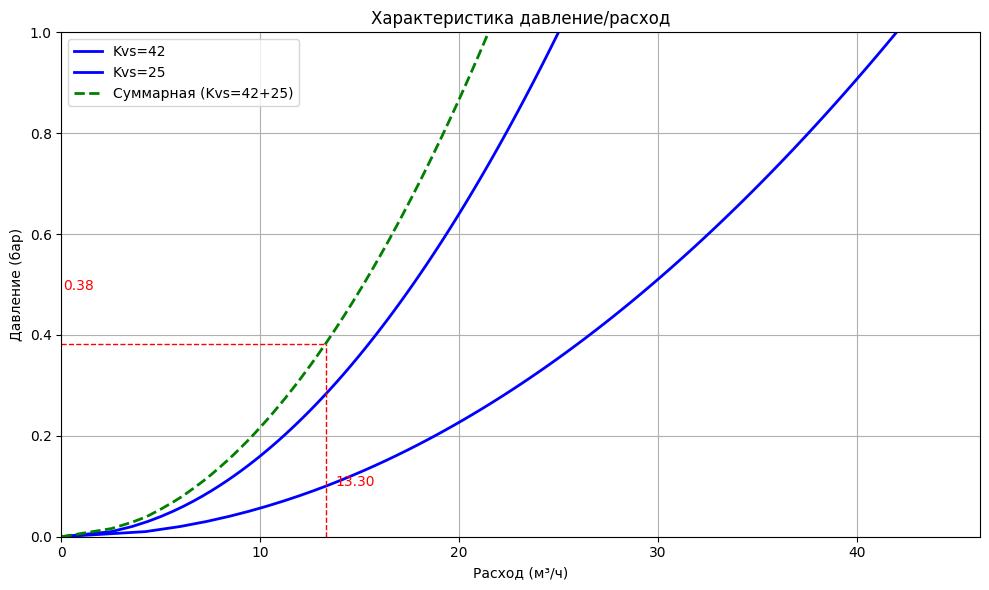

In [21]:
# Пример использования:
system = Flow_system(Kvs=42, P_max=1)
system.add_curve(Kvs=25)  # Добавляем вторую кривую
system.add_operating_point(Q_point=13.3)  # Добавляем точку на суммарной кривой
system.plot_curve()